In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

In [79]:
penuins_raw = pd.read_csv('penguins_preprocessed.csv')
penguins_df = pd.DataFrame(penuins_raw)
penguins_df.head()

,calorie requirement,average sleep duration,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,species_chinstrap,species_gentoo,island_dream,island_torgersen,gender_male
0,0.828324,0.571429,0.254545,0.666667,0.152542,0.291667,0.0,False,False,False,True,True
1,0.375305,1.000000,0.269091,0.511905,0.237288,0.305556,0.0,False,False,False,True,False
2,0.996480,0.571429,0.298182,0.583333,0.389831,0.152778,0.0,False,False,False,True,False
3,0.343894,0.142857,0.167273,0.738095,0.355932,0.208333,0.0,False,False,False,True,False
4,0.243434,0.857143,0.261818,0.892857,0.305085,0.263889,0.0,False,False,False,True,True


In [80]:
#The target variable will be the gender
print(penguins_df['gender_male'].value_counts())
target_col = "gender_male"
y = penguins_df[target_col].astype(int).to_numpy().reshape(-1, 1)
#need to reshape so itll work well with the regression


gender_male
True     153
False    147
Name: count, dtype: int64


In [81]:
X = penguins_df.drop(columns=[target_col]).to_numpy(dtype=float)
#dropping target variable and reshaping into a matrix to work well with regression


In [82]:
rng = np.random.default_rng(seed=42)
N = len(y)
perm = rng.permutation(N)
split = int(0.8 * N)
train_idx, test_idx = perm[:split], perm[split:]
#creating the train test split of the data and making it random
X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]
#applying the random split to the features and targets and creating the train test variables

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)

Train shapes: (240, 11) (240, 1)
Test  shapes: (60, 11) (60, 1)


In [83]:
class LogitRegression():
    def __init__(self, lr, num_iter):
        self.lr = lr
        self.num_iter = num_iter
        self.W = np.random.uniform(0,1)
        self.b = 0
        self.loss = []

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        #make sure z can't be extreme
        return 1 / (1 + np.exp(-z))

    def cost(self, y, y_hat):
        edge = 1e-12
        y_hat = np.clip(y_hat, edge, 1 - edge)
        return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)).mean()

    def gradient_descent(self, X, y, y_hat):
        N = X.shape[0]
        delta = y_hat - y           
        dW = (X.T @ delta) / N      
        db = np.mean(delta)         
        return dW, db

    def fit(self, X, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        #make sure y is a column
        N, d = X.shape
        self.W = np.zeros((d, 1))
        self.b = 0.0
        self.loss = []

        for _ in range(self.num_iter):
            z = X @ self.W + self.b  
            y_hat = self.sigmoid(z)
            loss_val = self.cost(y, y_hat)
            self.loss.append(loss_val)

            delta = y_hat - y
            dW = (X.T @ delta) / N
            db = delta.mean()
            self.W -= self.lr * dW
            self.b -= self.lr * db

    def predict(self, X):
        z = X @ self.W + self.b
        y_hat = self.sigmoid(z)
        return (y_hat >= 0.5).astype(int)
    
    def accuracy(self, y_true, y_pred):
        if y_true.ndim == 1: y_true = y_true.reshape(-1,1)
        if y_pred.ndim == 1: y_pred = y_pred.reshape(-1,1)
        #make sure the y's are one column
        return (y_true == y_pred).mean()
    
    def confusion_matrix(self, y_true, y_pred):
        if y_true.ndim == 1: y_true = y_true.reshape(-1,1)
        if y_pred.ndim == 1: y_pred = y_pred.reshape(-1,1)
        #make sure the y's are one column
        tp = np.sum((y_true==1) & (y_pred==1))
        tn = np.sum((y_true==0) & (y_pred==0))
        fp = np.sum((y_true==0) & (y_pred==1))
        fn = np.sum((y_true==1) & (y_pred==0))
        return np.array([[tn, fp],
                         [fn, tp]])
    
    def precision_recall_f1(self, y_true, y_pred):
        if y_true.ndim == 1: y_true = y_true.reshape(-1,1)
        if y_pred.ndim == 1: y_pred = y_pred.reshape(-1,1)
        #make sure the y's are one column
        tp = np.sum((y_true==1) & (y_pred==1))
        fp = np.sum((y_true==0) & (y_pred==1))
        fn = np.sum((y_true==1) & (y_pred==0))
        #summing up the true and false positives and negatives
        precision = tp / (tp + fp + 1e-12)
        recall    = tp / (tp + fn + 1e-12)
        f1        = 2*precision*recall / (precision + recall + 1e-12)
        #need the 1e-12 just in case tp+fn is 0 so I dont get a undefined
        return float(precision), float(recall), float(f1)

    

In [84]:
#model training
#1st setup
model = LogitRegression(1e-3, 100000)
model.fit(X_train, y_train)
pred = model.predict(X_test)

#accuracy score
print("Model Accuracy", model.accuracy(y_test, pred) * 100)
print("Precision", model.precision_recall_f1(y_test, pred))
print("Confusion Matrix", model.confusion_matrix(y_test, pred))

Model Accuracy 85.0
Precision (0.7714285714285494, 0.9642857142856799, 0.857142857142336)
Confusion Matrix [[24  8]
 [ 1 27]]


In [85]:
#2nd setup
model = LogitRegression(5e-3, 100000)
model.fit(X_train, y_train)
pred = model.predict(X_test)

#accuracy score
print("Model Accuracy", model.accuracy(y_test, pred) * 100)
print("Precision", model.precision_recall_f1(y_test, pred))
print("Confusion Matrix", model.confusion_matrix(y_test, pred))

Model Accuracy 93.33333333333333
Precision (0.89999999999997, 0.9642857142856799, 0.9310344827580892)
Confusion Matrix [[29  3]
 [ 1 27]]


In [86]:
#3rd setup
model = LogitRegression(10e-3, 100000)
model.fit(X_train, y_train)
pred = model.predict(X_test)

#accuracy score
acc = model.accuracy(y_test, pred)
print("Model Accuracy", acc * 100)
print("Precision", model.precision_recall_f1(y_test, pred))
print("Confusion Matrix", model.confusion_matrix(y_test, pred))

Model Accuracy 93.33333333333333
Precision (0.89999999999997, 0.9642857142856799, 0.9310344827580892)
Confusion Matrix [[29  3]
 [ 1 27]]


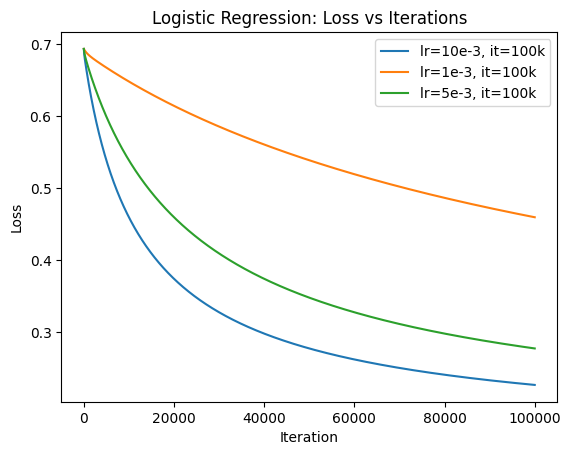

In [87]:
setups = [
    {"lr": 10e-3, "num_iter": 100000, "label": "lr=10e-3, it=100k"},
    {"lr": 1e-3, "num_iter": 100000, "label": "lr=1e-3, it=100k"},
    {"lr": 5e-3, "num_iter": 100000,  "label": "lr=5e-3, it=100k"},
]

results = []

for version in setups:
    model = LogitRegression(version["lr"], version["num_iter"])
    model.fit(X_train, y_train)

    # plot loss curve
    plt.plot(model.loss, label=version["label"])

    # evaluate accuracy
    y_pred = model.predict(X_test)
    acc = model.accuracy(y_test, y_pred)

    results.append((version["label"], model.loss[-1], acc))

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Iterations")
plt.legend()
plt.show()

The number of iterations didn't chance much, but the learning rate affected it the most. When I increased learning rate to 5e-3 it made the loss drop by a lot and increased accuracy compared to 1e-3. When increased to 10e-3 the loss also decreased, but the accuracy stays the same.

In [88]:
weights = {
    "W": model.W,
    "b": model.b,
    "lr": model.lr,
    "n_iter": model.num_iter,
    "accuracy": acc
}

with open("a1_part_2_weights_JadenPeacock.pkl", "wb") as f:
    pickle.dump(weights, f)

#This should save the weights into a pickle file


my best performing parameters had to be either when learning rate was 10e-3 or 5e-3 I would lean more towards 5e-3, since I had gotten a higher accuarcy before but it decreased for some reason, so it shows that there is room for increased accuracy using 5e-3.

The advantages and disadvantages to logistic regression is that it is simpler to implement compared to other models, but since it is a linear model if there isn't some type of relationship it will be hard to get a good relationship and therefore good results.

I faced a few issues, for some reason my y wouldn't be the dimensions I needed them to be so for most of the functions i had to do a check and if it wasn't the dimensions I needed, I made then what I needed. I also had trouble with the fit and gradient descent functions, so I found examples of what other people did and tried to see where I went wrong with what I did.

References:
https://wiki.python.org/moin/UsingPickle

https://heena-sharma.medium.com/logistic-regression-python-implementation-from-scratch-without-using-sklearn-d3fca7d3dae7

https://www.kaggle.com/code/sagira/logistic-regression-math-behind-without-sklearn
